# Lab 6: Graphical Models

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD6"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L6_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
from scipy.linalg import eigh, norm


## GLASSO method : 
Optimization problem : $\hat{P} = \underset{P \succ 0}{\arg\min} \left( -\log \det P + \operatorname{trace}(SP) + \lambda \|P\|_1 \right)$. Where $\hat{P}$ estimates $\Sigma^{-1}$ of the GGM parameters $(\mu, \Sigma)$.

Resolution method : ADMM


In [11]:
class my_GLasso():
    
    def __init__(self, lambd=0.01, nu=0.01, max_iter = 60):
        '''
        Parameters:
        lamb : float
            Penalization parameter selected
        nu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.nu = nu
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # Initialization
        S = np.cov(X, rowvar=False)  # Empirical covariance matrix
        n = S.shape[0]
        P = np.eye(n)  # Precision matrix
        Z = np.eye(n)  # Auxiliary variable
        U = np.zeros_like(P)  # Dual variable
        
        
        # ADMM
        for _ in tqdm(range(self.max_iter), desc="ADMM Progress"):
            # Step 1: Update P (minimize over P)
            eigvals, eigvecs = eigh(self.nu * (Z - U) - S)
            eigvals = (eigvals + np.sqrt(eigvals**2 + 4 * self.nu)) / (2 * self.nu)  
            P = eigvecs @ np.diag(eigvals) @ eigvecs.T
            
            # Step 2: Update Z (minimize over Z with L1 penalty)
            Z = np.sign(P + U) * np.maximum(np.abs(P + U) - self.lambd / self.nu, 0)
            # Step 3: Update U (dual variable update)
            U += P - Z
            
        # Step 3: Store results
        self.covariance_ = np.linalg.inv(P)  # Covariance matrix (inverse precision)
        self.precision_ = P  # Precision matrix
        
        return self


ADMM Progress: 100%|██████████| 10000/10000 [00:01<00:00, 6002.43it/s]


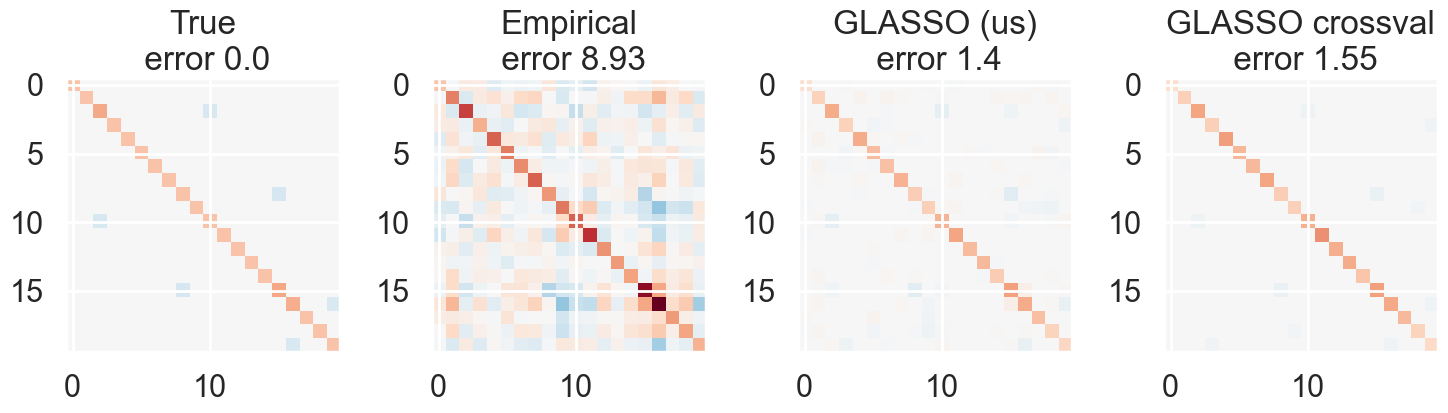

In [42]:
# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Scikit-learn Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV
model_glassocv = GraphicalLassoCV()
model_glassocv.fit(data)
prec_glassocv = model_glassocv.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
my_glasso = my_GLasso(lambd=0.1, nu=0.01, max_iter=10000)  # Adjust parameters if necessary
my_glasso.fit(data)
prec_glasso = my_glasso.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)

# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))

#windows 
vmax = max(
    np.abs(prec).max(),
    np.abs(prec_empirical).max(),
    np.abs(prec_glasso).max(),
    np.abs(prec_glassocv).max()
)
vmin = -vmax

for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [43]:
class my_nodewise_regression():
    
    def __init__(self, rule='AND', eps=1e-8):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacancy matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        n_samples, n_features = X.shape
        adjacency_matrix = np.zeros((n_features, n_features))
        
        for i in tqdm(range(n_features), desc="Nodewise Regression Progress"):
            y = X[:, i]  # Feature to predict (response)
            feature_indices = [j for j in range(n_features) if j != i]
            X_predictors = X[:, feature_indices]  # All other features (predictors)
            
            # Fit LassoCV to perform nodewise regression
            lasso = LassoCV(cv=5, max_iter=10000)
            lasso.fit(X_predictors, y)
            non_zero_indices = np.abs(lasso.coef_) > self.eps
            
            # Map back to original feature indices
            non_zero_features = np.array(feature_indices)[non_zero_indices]
            
            # Update adjacency matrix
            adjacency_matrix[i, non_zero_features] = 1  # Edge from i to non_zero_features
        
        # Symmetrize the adjacency matrix based on the selected rule
        if self.rule == 'AND':
            self.graph_structure_ = np.logical_and(adjacency_matrix, adjacency_matrix.T).astype(int)
        elif self.rule == 'OR':
            self.graph_structure_ = np.logical_or(adjacency_matrix, adjacency_matrix.T).astype(int)
        else:
            raise ValueError("Invalid rule. Must be 'AND' or 'OR'")
        
        return self

In [44]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

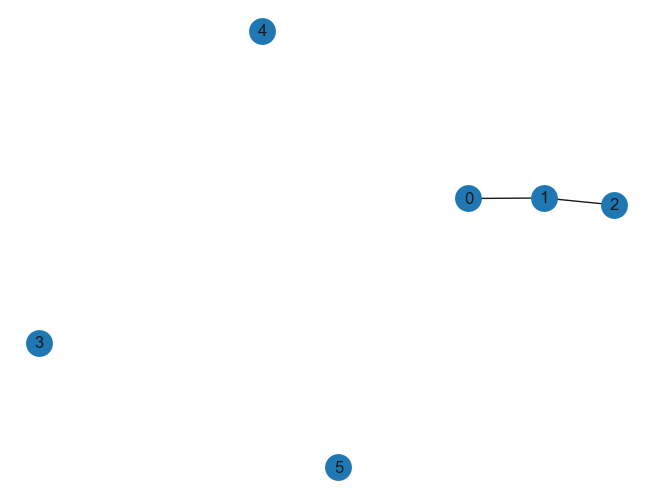

In [45]:
nx_real = nx.from_numpy_array(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)

#On dessine la structure initiale

We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

ADMM Progress: 100%|██████████| 10000/10000 [00:00<00:00, 11588.74it/s]


X shape is : (5000, 6)
cov : [[1.21546789e+00 8.04946597e-01 7.82310418e-01 1.16154960e-03
  4.43183478e-03 1.65363074e-03]
 [8.04946597e-01 2.16778865e+00 1.74521584e+00 2.30626567e-03
  8.80846403e-03 3.28406127e-03]
 [7.82310418e-01 1.74521584e+00 3.12259594e+00 2.93962917e-03
  1.12366377e-02 4.18644354e-03]
 [1.16154960e-03 2.30626567e-03 2.93962917e-03 1.18923231e+00
  4.50301299e-07 2.34309962e-06]
 [4.43183478e-03 8.80846403e-03 1.12366377e-02 4.50301299e-07
  1.21298282e+00 2.84334269e-05]
 [1.65363074e-03 3.28406127e-03 4.18644354e-03 2.34309962e-06
  2.84334269e-05 1.19422292e+00]] 
 corr : [[1.00000000e+00 4.95891717e-01 4.01559100e-01 9.66123538e-04
  3.64992962e-03 1.37253710e-03]
 [4.95891717e-01 1.00000000e+00 6.70784135e-01 1.43637394e-03
  5.43205791e-03 2.04108025e-03]
 [4.01559100e-01 6.70784135e-01 1.00000000e+00 1.52546168e-03
  5.77365938e-03 2.16792694e-03]
 [9.66123538e-04 1.43637394e-03 1.52546168e-03 1.00000000e+00
  3.74923381e-07 1.96614119e-06]
 [3.6499296

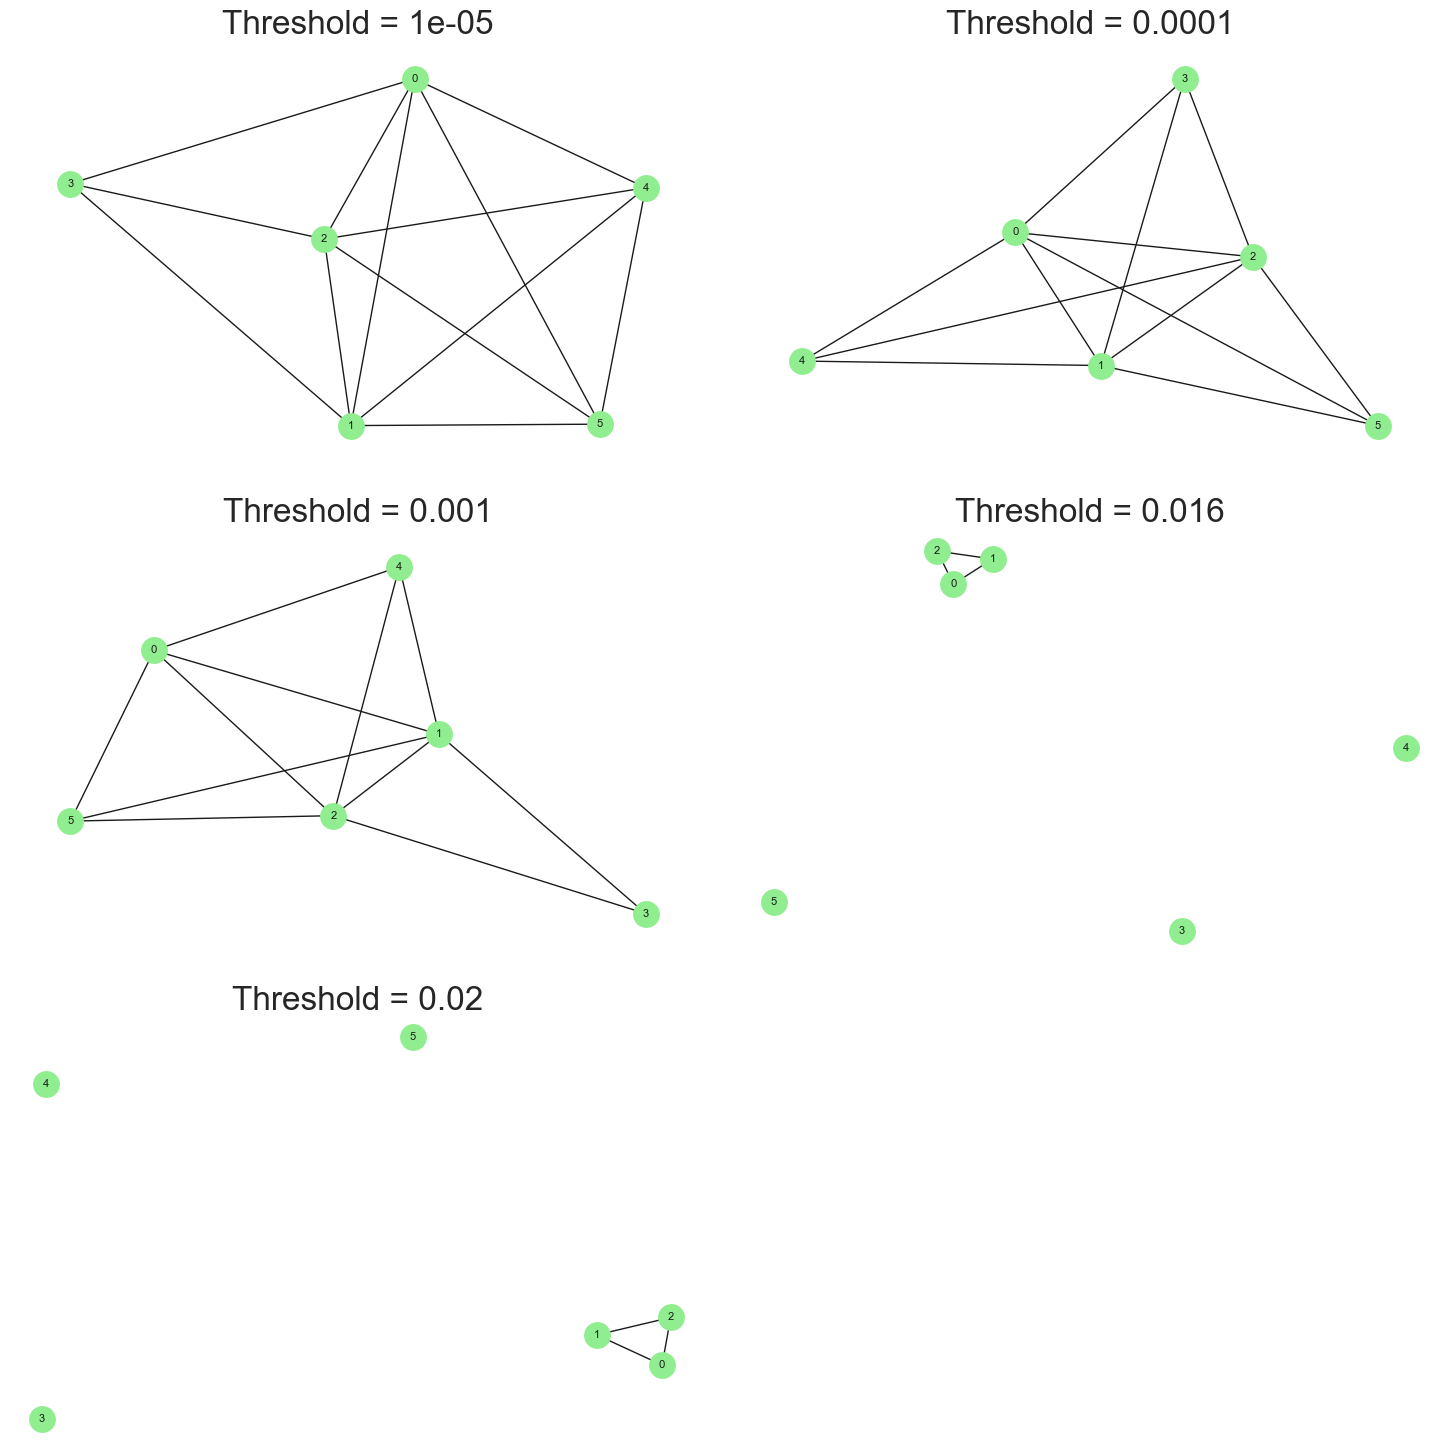

In [46]:
# Fit the Graphical Lasso model
my_glasso = my_GLasso(lambd=0.2, nu=0.001, max_iter=10000)
my_glasso.fit(X)
print(f'X shape is : {X.shape}')
diag = np.sqrt(np.diag(my_glasso.covariance_))
corr_matrix = my_glasso.covariance_ / np.outer(diag, diag)
np.fill_diagonal(corr_matrix, 1)  # Ensure diagonal is exactly 1
print(f'cov : {my_glasso.covariance_} \n corr : {corr_matrix}')
# List of thresholds to test
thresholds = [1e-5, 1e-4, 1e-3, 0.016, 0.02]

n_thresholds = len(thresholds)
n_cols = 2  # Set number of columns for better readability
n_rows = (n_thresholds + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Ensure 'axes' is a flat array for consistent indexing
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = np.array([axes])  # When there's only one subplot

for idx, epsilon in enumerate(thresholds):
    ax = axes[idx]  # Use flat indexing

    # Create adjacency matrix with the current threshold
    adj_matrix = np.abs(corr_matrix) > epsilon
    np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

    # Reconstruct graph using adjacency matrix
    nx_reconstructed = nx.from_numpy_array(adj_matrix)

    # Plot the reconstructed graph
    nx.draw(
        nx_reconstructed,
        with_labels=True,
        node_color="lightgreen",
        node_size=300,
        font_size=8,
        ax=ax
    )
    ax.set_title(f"Threshold = {epsilon}")

# Hide any empty subplots
for idx in range(n_thresholds, n_rows * n_cols):
    axes[idx].axis("off")
fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

Remark : we get it for a threshold of 0.2 with these params.

Nodewise Regression Progress: 100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


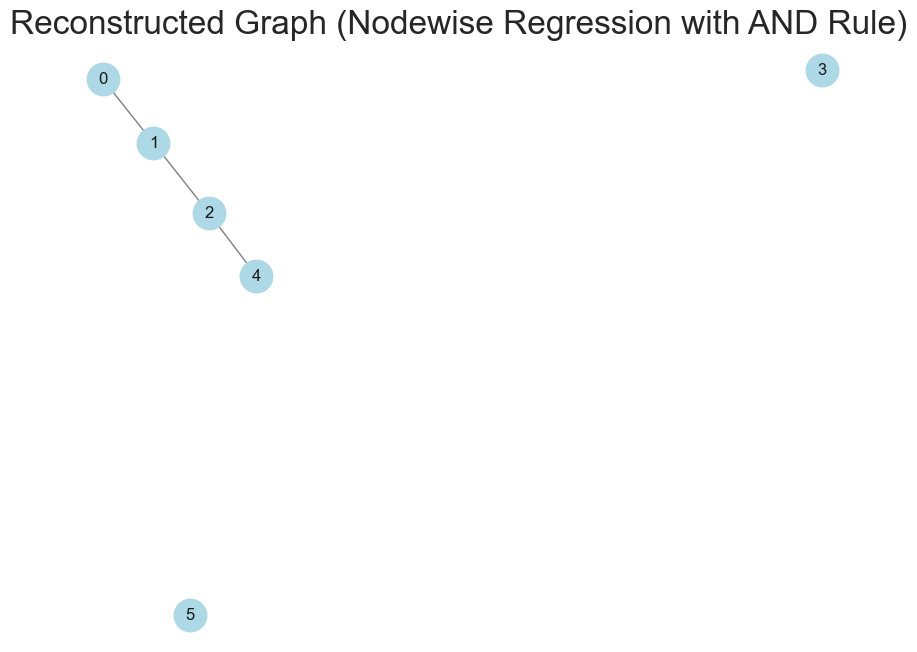

In [47]:
nodewise_model = my_nodewise_regression(rule='AND')
nodewise_model.fit(X)
graph_structure = nodewise_model.graph_structure_

def plot_graph_with_nodewise_regression(adjacency_matrix, title):
    G = nx.from_numpy_array(adjacency_matrix)
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)
    plt.title(f'{title}')
    plt.show()

plot_graph_with_nodewise_regression(nodewise_model.graph_structure_, 'Reconstructed Graph (Nodewise Regression with AND Rule)')


Nodewise Regression Progress: 100%|██████████| 6/6 [00:00<00:00, 10.54it/s]


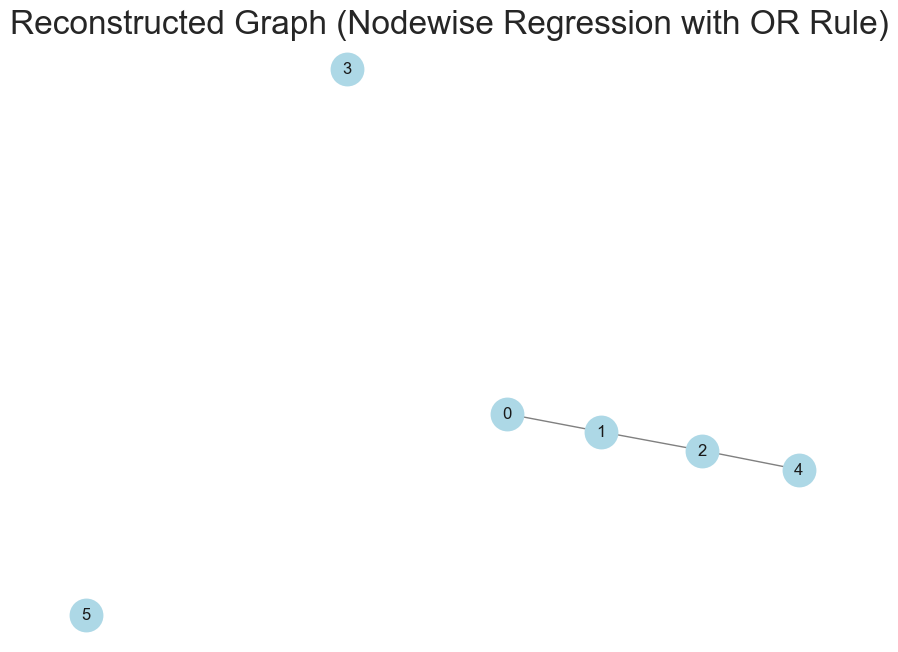

In [48]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
nodewise_model = my_nodewise_regression(rule='AND')
nodewise_model.fit(X)
graph_structure = nodewise_model.graph_structure_

def plot_graph_with_nodewise_regression(adjacency_matrix, title):
    G = nx.from_numpy_array(adjacency_matrix)
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)
    plt.title(f'{title}')
    plt.show()

plot_graph_with_nodewise_regression(nodewise_model.graph_structure_, 'Reconstructed Graph (Nodewise Regression with OR Rule)')


## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [52]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Parameters
p = 300
block_size = 30
rho = 0.9
n_samples_list = [40, 80, 320]

# AR(1)-Block Model
cov_true_ar = np.zeros((p, p))
for b in range(p // block_size):
    idx = slice(b * block_size, (b + 1) * block_size)
    ar1_block = rho ** np.abs(np.subtract.outer(np.arange(block_size), np.arange(block_size)))
    cov_true_ar[idx, idx] = ar1_block
precision_true_ar = np.linalg.inv(cov_true_ar)
adjacency_true_ar = (np.abs(precision_true_ar) > 1e-4).astype(int)
np.fill_diagonal(adjacency_true_ar, 0)

# Exponential Decay Model
indices = np.arange(p)
precision_true_exp = np.exp(-2 * np.abs(np.subtract.outer(indices, indices)))
cov_true_exp = np.linalg.inv(precision_true_exp)
adjacency_true_exp = (np.abs(precision_true_exp) > 1e-2).astype(int)
np.fill_diagonal(adjacency_true_exp, 0)

# Simulation
for model_name, (cov_true, precision_true, adjacency_true) in zip(
    ["AR(1)-Block", "Exponential Decay"],
    [(cov_true_ar, precision_true_ar, adjacency_true_ar), 
     (cov_true_exp, precision_true_exp, adjacency_true_exp)]
):
    print(f"\nModel: {model_name}")
    for n_samples in n_samples_list:
        print(f"  Sample Size: {n_samples}")
        
        # Generate data
        data = np.random.multivariate_normal(np.zeros(p), cov_true, size=n_samples)
        data = StandardScaler().fit_transform(data)
        if np.any(np.isnan(data)) or np.any(np.isinf(data)):
            print("Warning: NaN or Inf detected in data. Replacing with zeros.")
            data = np.nan_to_num(data)
        
        # Graphical Lasso
        model_glasso = GraphicalLassoCV(cv=5)
        model_glasso.fit(data)
        estimated_precision_glasso = model_glasso.precision_
        fro_norm_glasso = np.linalg.norm(precision_true - estimated_precision_glasso, ord='fro')
        print(f"    GLasso Frobenius Norm: {fro_norm_glasso:.4f}")
        
        # Node-wise Regression
        adjacency_estimated = np.zeros((p, p))
        for i in tqdm(range(p), desc="    Node-wise Regression"):
            X = np.delete(data, i, axis=1)
            y = data[:, i]
            lasso = LassoCV(cv=5, n_jobs=-1, max_iter=10000).fit(X, y)
            coefs = lasso.coef_
            coefs_full = np.insert(coefs, i, 0)
            adjacency_estimated[i, :] = coefs_full
        adjacency_estimated = np.abs(adjacency_estimated) > 1e-2
        adjacency_estimated_binary = adjacency_estimated.astype(int)
        
        accuracy = accuracy_score(adjacency_true.flatten(), adjacency_estimated_binary.flatten())
        f1 = f1_score(adjacency_true.flatten(), adjacency_estimated_binary.flatten())
        print(f"    Node-wise Regression Accuracy: {accuracy:.4f}")
        print(f"    Node-wise Regression F1 Score: {f1:.4f}")



Model: AR(1)-Block
  Sample Size: 40


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\sklearn\covariance\_graph_lasso.py:167: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\sklearn\covariance\_graph_lasso.py:168: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 151.1565


    Node-wise Regression: 100%|██████████| 300/300 [00:22<00:00, 13.36it/s]


    Node-wise Regression Accuracy: 0.9786
    Node-wise Regression F1 Score: 0.3760
  Sample Size: 80


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 149.2577


    Node-wise Regression: 100%|██████████| 300/300 [00:20<00:00, 14.59it/s]


    Node-wise Regression Accuracy: 0.9850
    Node-wise Regression F1 Score: 0.4616
  Sample Size: 320


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 148.5810


    Node-wise Regression: 100%|██████████| 300/300 [01:08<00:00,  4.35it/s]


    Node-wise Regression Accuracy: 0.9921
    Node-wise Regression F1 Score: 0.6187

Model: Exponential Decay
  Sample Size: 40


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 3.3576


    Node-wise Regression: 100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


    Node-wise Regression Accuracy: 0.9723
    Node-wise Regression F1 Score: 0.0266
  Sample Size: 80


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 3.3401


    Node-wise Regression: 100%|██████████| 300/300 [00:30<00:00,  9.70it/s]


    Node-wise Regression Accuracy: 0.9744
    Node-wise Regression F1 Score: 0.0400
  Sample Size: 320


C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


    GLasso Frobenius Norm: 3.1490


    Node-wise Regression:  39%|███▉      | 117/300 [03:46<04:48,  1.58s/it]C:\Users\boist\PycharmProjects\ML_avanced_3A\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e-02, tolerance: 2.417e-02
  model = cd_fast.enet_coordinate_descent(
    Node-wise Regression: 100%|██████████| 300/300 [09:01<00:00,  1.81s/it]

    Node-wise Regression Accuracy: 0.9784
    Node-wise Regression F1 Score: 0.1709
